#Logistic regression

In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import sys
from io import StringIO

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project/dataset/train.csv')

In [ ]:
#Prima di eseguire questo script sarebbe opportuno controllare che le date sono ordinate in ordine crescente

weather_names =['_temperature_','_rain_mm_','_humidity_','_wind_speed_','_pressure_']

for name in weather_names:
  df['max'+name+'prev14d']=df['max'+name+'prev7d']
  df['max'+name+'prev7d_shift']=df['max'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df['DATE']>'2019-04-16', 'max'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['max'+name+'prev7d','max'+name+'prev7d_shift']].max(axis=1)
  df=df.drop(columns=['max'+name+'prev7d_shift'])

  df['min'+name+'prev14d']=df['min'+name+'prev7d']
  df['min'+name+'prev7d_shift']=df['min'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'min'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['min'+name+'prev7d','min'+name+'prev7d_shift']].min(axis=1)
  df=df.drop(columns=['min'+name+'prev7d_shift'])

  df['mean'+name+'prev14d']=df['mean'+name+'prev7d']
  df['mean'+name+'prev7d_shift']=df['mean'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'mean'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['mean'+name+'prev7d','mean'+name+'prev7d_shift']].mean(axis=1)
  df=df.drop(columns=['mean'+name+'prev7d_shift'])

persistance_names =['equipment','fire/smoke','ge','power','temperature']

for name in persistance_names:
  df[name+'_max_persistance_prev14d']=df[name+'_max_persistance_prev7d']
  df[name+'_max_persistance_prev7d_shift']=df[name+'_max_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_max_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_max_persistance_prev7d',name+'_max_persistance_prev7d_shift']].max(axis=1)
  df=df.drop(columns=[name+'_max_persistance_prev7d_shift'])
  
  df[name+'_min_persistance_prev14d']=df[name+'_min_persistance_prev7d']
  df[name+'_min_persistance_prev7d_shift']=df[name+'_min_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_min_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_min_persistance_prev7d',name+'_min_persistance_prev7d_shift']].min(axis=1)
  df=df.drop(columns=[name+'_min_persistance_prev7d_shift'])

  df[name+'_mean_persistance_prev14d']=df[name+'_mean_persistance_prev7d']
  df[name+'_mean_persistance_prev7d_shift']=df[name+'_mean_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_mean_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_mean_persistance_prev7d',name+'_mean_persistance_prev7d_shift']].mean(axis=1)
  df=df.drop(columns=[name+'_mean_persistance_prev7d_shift'])

In [ ]:
#drop unused columns
df = df.drop(columns='CELL_TYPE_TRP')
df = df.drop(columns='SITE_ID')

#process data feature
df['DATE'] = pd.to_datetime(df['DATE'])
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df['year'] = df['DATE'].dt.year % 2019
df = df.drop(columns='DATE')

df['day'] = df['day'] - 1

In [ ]:
def cyclical_encoding(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

In [ ]:
df_14d_plus = df[[col for col in df.columns if '3d' not in col and '7d' not in col and 'CELL_TYPE_' not in col and 'year' not in col and 'month' not in col]]
df_14d_plus.head()

,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_f_next14d,max_temperature_f_next14d,min_temperature_f_next14d,mean_rain_mm_f_next14d,max_rain_mm_f_next14d,min_rain_mm_f_next14d,mean_humidity_f_next14d,max_humidity_f_next14d,min_humidity_f_next14d,mean_wind_speed_f_next14d,max_wind_speed_f_next14d,min_wind_speed_f_next14d,mean_pressure_f_next14d,max_pressure_f_next14d,min_pressure_f_next14d,equipment_sum_alarms_prev14d,fire/smoke_sum_alarms_prev14d,ge_sum_alarms_prev14d,power_sum_alarms_prev14d,temperature_sum_alarms_prev14d,skew_equipment_alarms_prev14d,skew_fire/smoke_alarms_prev14d,skew_ge_alarms_prev14d,skew_power_alarms_prev14d,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,max_temperature_prev14d,min_temperature_prev14d,mean_temperature_prev14d,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,day
0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.00,12.0,5.0,4.79,19.6,0.1,74.29,89.0,58.0,12.86,17.0,5.0,1020.71,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,14.0,6.0,10.29,8.5,0.0,1.33,81.0,45.0,62.71,16.0,5.0,11.43,1022.0,1006.0,1013.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.50,16.0,5.0,3.52,12.5,0.1,72.93,89.0,58.0,12.57,17.0,5.0,1021.71,1028.0,1013.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.71,8.5,0.0,1.90,81.0,51.0,66.43,16.0,5.0,11.57,1017.0,1006.0,1010.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
2,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,9.36,20.0,5.0,3.63,12.5,0.1,72.00,89.0,58.0,12.29,17.0,5.0,1022.14,1028.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.57,19.6,0.0,4.70,88.0,58.0,71.71,16.0,5.0,11.71,1015.0,1006.0,1009.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
3,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,10.57,22.0,5.0,3.40,12.5,0.1,70.07,89.0,58.0,12.14,17.0,5.0,1021.86,1028.0,1012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,8.0,11.29,19.6,0.0,4.77,88.0,58.0,74.29,16.0,5.0,11.43,1013.0,1006.0,1009.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
4,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,11.50,22.0,5.0,3.49,12.5,0.1,69.07,89.0,58.0,11.64,17.0,5.0,1021.29,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,5.0,10.57,19.6,0.3,5.39,88.0,58.0,77.29,15.0,5.0,10.86,1016.0,1006.0,1009.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13


In [ ]:
df_to_norma = df_14d_plus[[col for col in df_14d_plus.columns if 'aircon_sum' not in col and 'GEOGRAPHIC_CLUSTER_' not in col and 'day' not in col]]
df_not_to = df_14d_plus[[col for col in df_14d_plus.columns if 'aircon_sum' in col or 'GEOGRAPHIC_CLUSTER_' in col and 'day' not in col]]
df_day = df_14d_plus[['day']]

In [ ]:
df_day = cyclical_encoding(df_day, 'day', 30)
df_day = df_day.drop(columns='day')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
scaler = StandardScaler()
scaler.fit(df_to_norma)
norma = scaler.transform(df_to_norma)

df_norma = pd.DataFrame(norma, index=df_to_norma.index, columns=df_to_norma.columns)

In [ ]:
#Union of the dataframe
df_1 = pd.concat([df_norma, df_not_to], axis=1)
df_14d_plus_ok = pd.concat([df_1, df_day], axis=1)

In [ ]:
X = df_14d_plus_ok.drop(columns=['aircon_sum_target_next14d'])
y = df_14d_plus_ok['aircon_sum_target_next14d']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0, stratify = y)

#Logistic regression

In [ ]:
simple_logistic = linear_model.LogisticRegression(C=1250, max_iter=2000,random_state=0, 
                                                  solver='saga', penalty='elasticnet', l1_ratio =0.5)
result=simple_logistic.fit(X_train,y_train);
result.coef_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([[ 0.13422136,  0.45988357,  0.58901459,  0.02531989,  0.09099498,
        -0.05466725, -0.09614967, -0.06134021,  0.07881615,  0.09853142,
        -0.2661427 ,  0.08784384,  0.02447612, -0.03379444,  0.08967609,
         0.04561845,  0.04125132,  0.12955106, -0.04493403, -0.03409317,
         0.04066901, -0.01512946, -0.02149274,  0.02856445, -0.01910079,
         0.01385518,  0.02458088,  0.04328631, -0.03960646, -0.00788883,
         0.0311446 , -0.50044373, -0.04838686,  0.02574413,  0.04099106,
         0.00282266,  0.02378859, -0.11469747,  0.16609546, -0.01275518,
         0.08549109,  0.17099721, -0.19421703, -0.06786586, -0.1803334 ,
         0.09368413, -0.16200536, -0.05330911,  0.15961423, -0.07374942,
        -0.45754953, -0.20026773, -0.06629996,  0.        ,  0.09465682,
        -0.00679549, -0.03774316,  0.09718218,  0.00987947, -0.09525283,
         0.04235677, -0.8439997 , -0.85264123, -0.22501661,  0.26870153,
        -0.80721914, -0.86199484, -0.4530433 , -0.7

Accuracy:  0.994205697730565
Precision:  0.45652173913043476
Recall:  0.0234375
F1 score:  0.044585987261146494


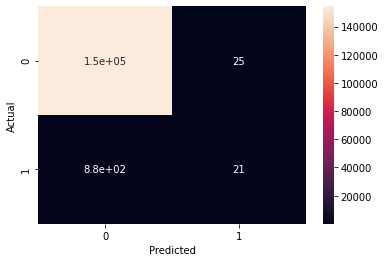

In [ ]:
y_pred = simple_logistic.predict(X_test);
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('F1 score: ', metrics.f1_score(y_test, y_pred))

plt.show()

#SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log", penalty="l2", max_iter=2000, tol=0.00001)
result_sgd=clf.fit(X_train,y_train)
result_sgd.coef_

array([[ 0.12743962,  0.38712667,  0.51807549,  0.04146205,  0.0934806 ,
        -0.03742766, -0.08605721, -0.01266161,  0.09102904,  0.07731449,
        -0.2323146 ,  0.05423806,  0.00448861, -0.05581154,  0.09424531,
         0.06431129,  0.03303812,  0.12657637, -0.03132146, -0.03598007,
         0.04733606, -0.01907731, -0.03004252,  0.02900134, -0.00931495,
        -0.01019962,  0.00716073,  0.0418698 , -0.02979265, -0.03967282,
         0.0313571 , -0.42508977, -0.04838639,  0.08418816,  0.04087206,
         0.00688048,  0.04186608, -0.04506237,  0.18933716,  0.00964927,
         0.05714449,  0.13874775, -0.18077032, -0.05377104, -0.15891505,
         0.07256135, -0.1309571 , -0.05976325,  0.13671452, -0.05421302,
        -0.42374958, -0.21621491, -0.07954876,  0.        ,  0.12378613,
        -0.01685576, -0.04769668,  0.08410974,  0.0122995 , -0.08978287,
         0.04979453,  0.6952571 ,  0.74475091,  1.22312457,  1.67353663,
         0.74730139,  0.70889675,  1.02101721,  0.8

Accuracy:  0.9942250120714631
Precision:  0.4883720930232558
Recall:  0.0234375
F1 score:  0.04472843450479233


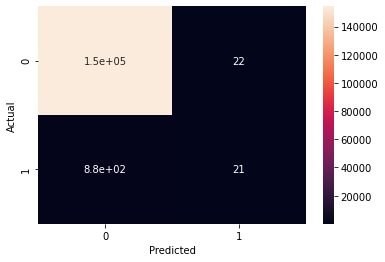

In [ ]:
y_pred = result_sgd.predict(X_test);
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('F1 score: ', metrics.f1_score(y_test, y_pred))

plt.show()

#Time series